Module imports...

In [3]:
import numpy as np

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

### Section Goal:

Now, the telescope has theoretically been calibrated so that the flux scale has units of Jansky's meaning it is now possible to search, meaningfully, for signals in the data. We would like to analyze the data to see if we can detect the pulsar we believe to be present.

## Part 1: Pulsar Period Folding for S/N ~ 2

We know the characteristics of the pulsar we wish to observe in the sense that we know its spectrum, but not its period. It has the following characteristics:

- $S_{\nu}$ = 400MHz
- $S_{400}$ = 0.15Jy
- $\alpha$ = -1.5

Again, this means we can model the pulsar spectrum as a power law with the following formula (inserting the corresponding parameters above):

$$S_{\nu} = S_{400}\left(\frac{\nu}{400}\right)^{-0.6}.$$

Additionally, we know that the signal-to-noise ratio (S/N) can be found via

$$S/N \propto \frac{S_{\nu}}{S_{sys}}\sqrt{N},$$

where $N$ is the total number of samples being integrated. Therefore, we can caluculate the (S/N) ratio using the spectrum parameters above and the blank sky average (and calibrated) spectrum (ie. $S_{sys}$) using the data from the previous part of the project.

In [5]:
#Re-using the function to plot the theoretical spectrum
#TODO: fill out the doc string
def theoretical_spectrum(freq, alpha, S):
    """
    Return the flux density in Jy for a given frequency in MHz

    Params
    ------
    freq
        The frequencies over which the spectrum is to be plotted
    alpha
        The Spectral Index
    S
        The reference flux density used to scale the spectrum to some established value at a given frequency

    Returns
    -------
    S_nu
        The flux density at a given frequency
    """
    return S*(freq/400.0)**alpha


And using the pular spectrum parameters to make a plot of the theoretical spectrum across the CHIME band.

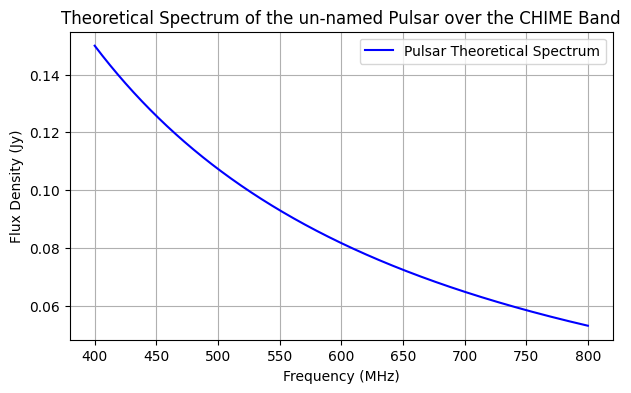

In [6]:
#Flux params of our calibrator source
alpha = -1.5
S400 = 0.15

#array of CHIME frequencies
#We go from 800 -> 400 to construct a theoretical flux array that is indexed
# in the same way. This way our theoretical flux array matches the indexing
# of the measured data set that has the frequencies in a decending order.
chime_freqs = np.linspace(400, 800, 1024)

#Calculate the theoretical flux at ehach frequency
flux_theory = theoretical_spectrum(chime_freqs, alpha, S400)

#Plot the theoretical spectrum
plt.figure(figsize=(7, 4))
plt.plot(chime_freqs, flux_theory, label='Pulsar Theoretical Spectrum', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux Density (Jy)')
plt.title('Theoretical Spectrum of the un-named Pulsar over the CHIME Band')
plt.legend()
plt.grid(True)
plt.show()

Let's load in the Numpy array representing the average blank sky spectrum from the previous part of the project and make a plot to recall what we're working with.

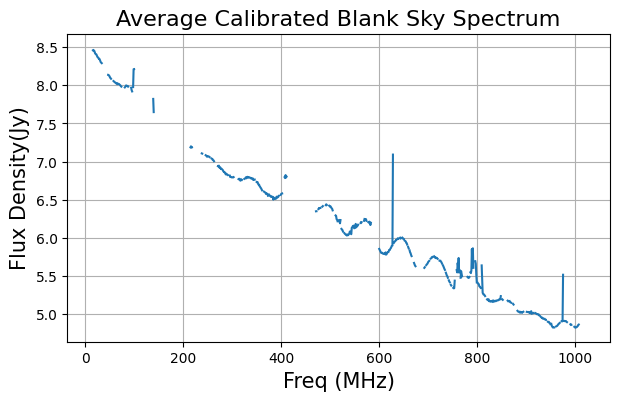

In [7]:
avg_blank_sky_spectrum = np.load('avg_blank_sky_spectrum.npy')

#Plotting average spectrum
fig, ax = plt.subplots(figsize = (7, 4))
ax.plot(avg_blank_sky_spectrum)
ax.set_title('Average Calibrated Blank Sky Spectrum', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Flux Density(Jy)', fontsize = 15)
ax.grid(True)
plt.show()

Now, we would like to go ahead and determine the (S/N) for a single pulse using the data above. The only piece we're missing is the total number of samples being integrated. If we double check the header info for the blank sky data set, we can check the number of channels that were presumably summed over to create the average spectrum for the blank sky.

In [8]:
blank_sky_Fil = FilReader('../data/blank_sky.fil')
Pretty(blank_sky_Fil.header)

Header(
    filename='../data/blank_sky.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (68.75000238, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='../data/blank_sky.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

There are 30518 samples that we integrated over when producing the average spectrum, so this is the value we should take for $N$ in the (S/N) formula above.

THIS IS NOT TRUE, SINCE THE SAMPLES HERE SEEM TO BE A DIFFERENT THING THEN THE SAMPLES DEFINED BY INTEGRATING FOR EACH PULSE ETC... NEED TO THINK A BIT MORE ABOUT THIS..

In [9]:
#defining the S/N function
def signal_to_noise(S_nu, S_sys, N):
    """
    Calculates the signal to expected signal to noise given the source flux
    density and a measure of the system equivalent flux density

    Params
    ------
    S_nu
        The source flux density
    S_sys
        The system equivalent flux density
    N
        Total number of samples being integrated

    Returns
    -------
    (S/N)
        The expected signal to noise ratio given the parameters provided
    """
    return (S_nu/S_sys) * np.sqrt(N)

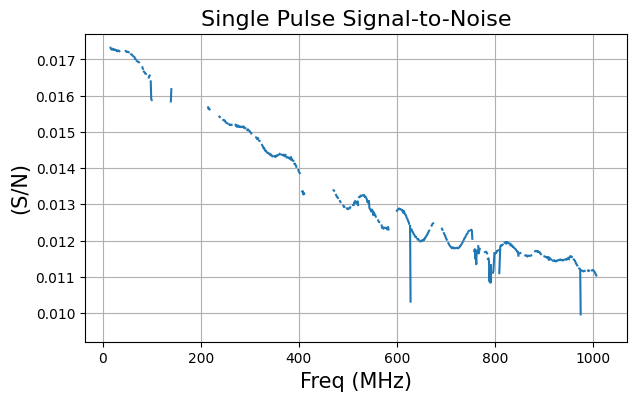

In [10]:
#using the function above, calculate the expected signal to noise
S_nu = flux_theory
S_sys = avg_blank_sky_spectrum
N_single_pulse = 1
S_to_N_1_pulse = signal_to_noise(S_nu, S_sys, N_single_pulse)

#Plot out the expected signal to noise as a function of frequency
fig, ax = plt.subplots(figsize = (7, 4))
# ax.plot(S_to_N_1_pulse)
ax.plot(np.where(S_to_N_1_pulse == 0, np.nan, S_to_N_1_pulse))
ax.set_title('Single Pulse Signal-to-Noise', fontsize = 16)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('(S/N)', fontsize = 15)
ax.grid(True)
plt.show()

To find the expected number of integrations (ie. $N$), we can use scipy.optimize to solve for the roots when the (S/N) = 2.

At this point, there are a number of ways we could derive a value of $N$ that corresponds to a (S/N) = 2, since both $S_{\nu}$ and $S_{sys}$ are arrays spanning across all of the frequency channels. Therefore, I will determine a value for the number of folds desired to create a signal-to-noise ratio of 2 for each of the following:

1. Averaging the (S/N) across all frequency channels
2. The worst (S/N) channel
3. A value of $N$ for each of the frequency channels

N for each of these scenarios provides slightly different information that may individually come in handy when determining what is required to produce the desired signal-to-noise given exposure time.

The frequency-averaged S/N for 1 pulse is 0.009994
The number of integrations required to achieve S/N ~2 for frequency-avged S/N is 40048.605007

Worst_SN_channel is 1020. The associated S/N is 0.009596.
The number of integrations required to achieve S/N ~2 for the worst S/N channel is 43442.205092

The number of integrations to achieve S/N ~ 2 for each of the different frequency channels can be seen in the plot below:


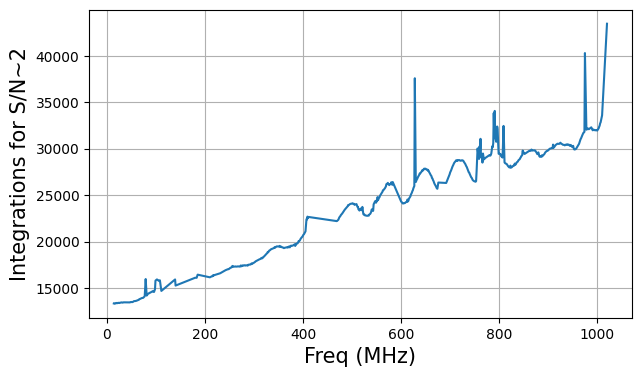

In [11]:
#beginning with finding N for average S/N
#----------------------------------------

#avg S/N for one pulse
S_N_avg = np.nanmean(signal_to_noise(S_nu, S_sys, 1))
print(f"The frequency-averaged S/N for 1 pulse is {S_N_avg:.6f}")

#Compute desired N to observe S/N of ~2
N_2_freq_avg = 4*(1/S_N_avg**2)
print(f"The number of integrations required to achieve S/N ~2 for frequency-avged S/N is {N_2_freq_avg:.6f}")

#N for the worst S/N channel
#---------------------
print()

#computing worst S/N channel
#first filter out 0 and nan entries in array
zero_nan_mask = (S_to_N_1_pulse != 0) & (~np.isnan(S_to_N_1_pulse))
# print(zero_nan_mask)
S_to_N_1_pulse_nonzero = np.array(S_to_N_1_pulse[zero_nan_mask])

worst_SN_channel = np.argmin(S_to_N_1_pulse_nonzero)
worst_SN = S_to_N_1_pulse_nonzero[worst_SN_channel]

#keeping track of the worst channal in terms of original frequencies
valid_inds = np.arange(len(S_to_N_1_pulse))[zero_nan_mask]
original_worst_index = valid_inds[worst_SN_channel]
print(f"Worst_SN_channel is {original_worst_index}. The associated S/N is {worst_SN:.6f}.")


#Compute desired N to observe S/N of ~2
N_2_worst_channel = 4*(1/worst_SN**2)
print(f"The number of integrations required to achieve S/N ~2 for the worst S/N channel is {N_2_worst_channel:.6f}")


#N for every channel (this is essentially the previous step but with N calculated for all channels, not just the worst)
#---------------------
print()

#compute desired N to observe S/N of ~2 over the whole S/n single pulse array
N_2_whole_array = 4*(1/S_to_N_1_pulse_nonzero**2)

#easiest to just plot the above array to visualise the different N values
print("The number of integrations to achieve S/N ~ 2 for each of the different frequency channels can be "
      "seen in the plot below:")
fig, ax = plt.subplots(figsize = (7, 4))
# ax.plot(S_to_N_1_pulse)
ax.plot(valid_inds, N_2_whole_array)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Integrations for S/N~2', fontsize = 15)
ax.grid(True)
plt.show()

So at the best S/N frequency channel (this seems to be at much lower frequencies) the total number of integrations is close to N=15000, while for the frequency averaged data and especially considering the channel with the worst S/N, the total number of integrations requires for S/N~2 is much closer to 40000. This indicates that a value closer to 40000 folds may be required to observe the pulsar signal with sufficiently low signal to noise.

## Part 2: Loading the Pulsar Data

We can begin by taking a look at the header file and then making a quick waterfall plot to see initially what the data looks like.

In [12]:
pulsar_Fil = FilReader('../data/pulsardata.fil')
Pretty(pulsar_Fil.header)

Header(
    filename='../data/pulsardata.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30517,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='../data/pulsardata.fil',
                hdrlen=414,
                datalen=124997632,
                nsamples=30517,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

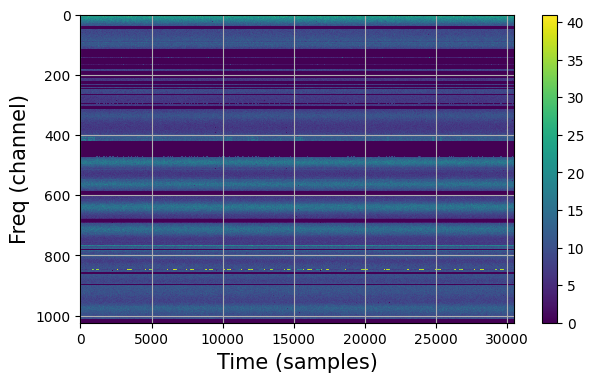

In [13]:
#create the pulsar data object
pulsar_data = pulsar_Fil.read_block(0,
                                    pulsar_Fil.header.nsamples,
                                    pulsar_Fil.header.fch1,
                                    pulsar_Fil.header.nchans
                                    )
pulsar_data_arr = pulsar_data.data

#make a quick waterfall plot of the pulsar data to see what we're working with
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(pulsar_data.data, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.grid(True)
plt.colorbar(im)
plt.show()

We can begin by flagging the pulsar data for RFI and get a plot of the S/N.

In [14]:
print(pulsar_data_arr.shape)

(1024, 30517)


In [15]:
#flagging rfi
_, chan_mask = pulsar_Fil.clean_rfi(method="mad", threshold=3)
pulsar_Fil_masked = FilReader('pulsardata_masked.fil')

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### Plotting rfi-flagged pulsar data

In [16]:
pulsar_Fil.compute_stats()

In [17]:
pulsar_Fil_masked.compute_stats()

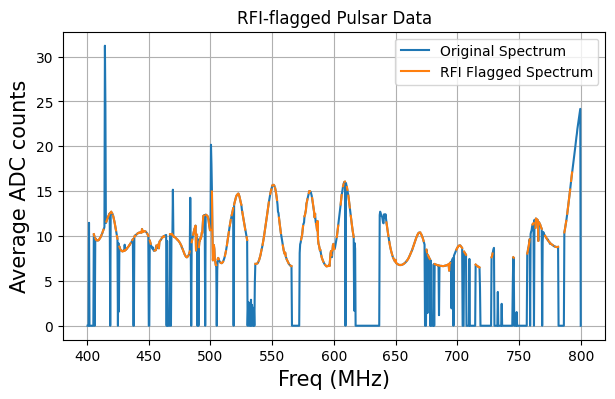

In [18]:
freq_mask = pulsar_Fil_masked.chan_stats.mean == 0
fig, ax = plt.subplots(figsize = (7, 4))
ax.set_title('RFI-flagged Pulsar Data')
ax.plot(pulsar_Fil_masked.header.chan_freqs,
        pulsar_Fil.chan_stats.mean,
        label = 'Original Spectrum'
        )
ax.plot(pulsar_Fil_masked.header.chan_freqs,
        np.where(~freq_mask, pulsar_Fil_masked.chan_stats.mean, np.nan),
        label = 'RFI Flagged Spectrum')
ax.set_xlabel('Freq (MHz)', fontsize = 15)
ax.set_ylabel('Average ADC counts', fontsize = 15)
ax.legend()
ax.grid(True)
plt.show()

### Normalizing and Visaulizing the Pulsar Data

In [19]:
#read in the masked pulsar data converting it to an actual array
pulsar_masked_data = pulsar_Fil_masked.read_block(0,
                                                  pulsar_Fil_masked.header.nsamples, pulsar_Fil_masked.header.fch1,
                                                  pulsar_Fil_masked.header.nchans
                                                  )

#unnormalized pulsar data loaded in as a numpy array
pulsar_masked_data_array = pulsar_masked_data.data

#Normalizing the data and standardizing across all channels (manually)
# norm_pulsar_data = (pulsar_masked_data_array - pulsar_Fil_masked.chan_stats.mean[:, None])/pulsar_Fil_masked.chan_stats.std[:, None]

#computing the normalized data and leaving as a filterbank object
#this option for normalizing is better for utilizing future sigpyproc functionalities
# norm_pulsar_Fil = pulsar_masked_data.normalise()
norm_pulsar_Fil = pulsar_masked_data.normalise()

Note we can first take a look at the masked (but unnormalized) Pulsar waterfall profile.

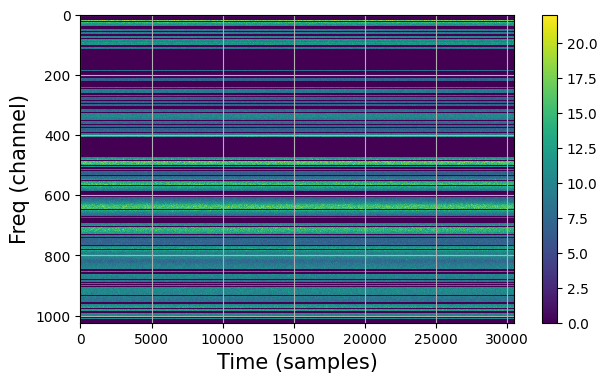

In [20]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(pulsar_masked_data_array, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.grid(True)
plt.colorbar(im)
plt.show()

### Plotting Normalized Pulsar Data

#### Water Fall

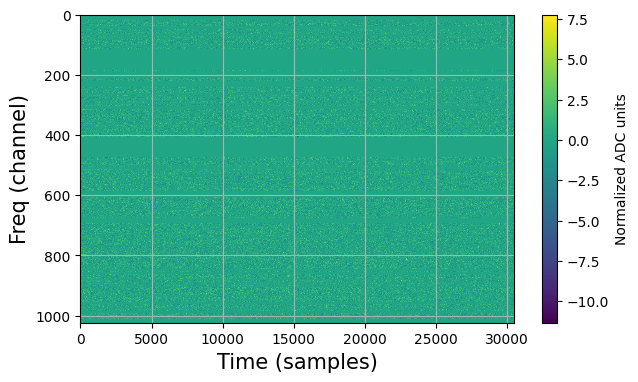

In [21]:
#make a quick waterfall plot of the pulsar data to see what we're working with
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(norm_pulsar_Fil.data, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.grid(True)
plt.colorbar(im, label='Normalized ADC units')
plt.show()

### Downsampling and Visualizing Again..

There aren't any obvious signs of a pulsar signal present in the waterfall plot shown above, so let's downsample to try and boost the signal to noise.

To downsample, we need to begin with the FilReader instance and then normalize once again.

Testing out with different amounts of downsampling..

In [22]:
#downsampling -> creates a new file that I load in below
pulsar_Fil_masked.downsample(tfactor=32)
pulsar_Fil_masked.downsample(tfactor=128)
pulsar_Fil_masked.downsample(tfactor=150)

'pulsardata_masked_f1_t150.fil'

In [23]:
#create the FilReader object
pulsar_Fil_masked_32 = FilReader('pulsardata_masked_f1_t32.fil')
pulsar_Fil_masked_128 = FilReader('pulsardata_masked_f1_t128.fil')
pulsar_Fil_masked_150 = FilReader('pulsardata_masked_f1_t150.fil')


#need to read in again in order to normalize and creat the waterfall plot
#read in the masked pulsar data converting it to an actual array
pulsar_masked_32_data = pulsar_Fil_masked_32.read_block(0,
                                            pulsar_Fil_masked_32.header.nsamples, 
                                            pulsar_Fil_masked_32.header.fch1,
                                            pulsar_Fil_masked_32.header.nchans
                                                  )
norm_pulsar_Fil_32 = pulsar_masked_32_data.normalise()

#loading in the different downsampled data
pulsar_masked_128_data = pulsar_Fil_masked_128.read_block(0,
                                            pulsar_Fil_masked_128.header.nsamples, 
                                            pulsar_Fil_masked_128.header.fch1,
                                            pulsar_Fil_masked_128.header.nchans
                                                  )
norm_pulsar_Fil_128 = pulsar_masked_128_data.normalise()

#loading in the different downsampled data
pulsar_masked_150_data = pulsar_Fil_masked_150.read_block(0,
                                            pulsar_Fil_masked_150.header.nsamples, 
                                            pulsar_Fil_masked_150.header.fch1,
                                            pulsar_Fil_masked_150.header.nchans
                                                  )
norm_pulsar_Fil_150 = pulsar_masked_150_data.normalise()


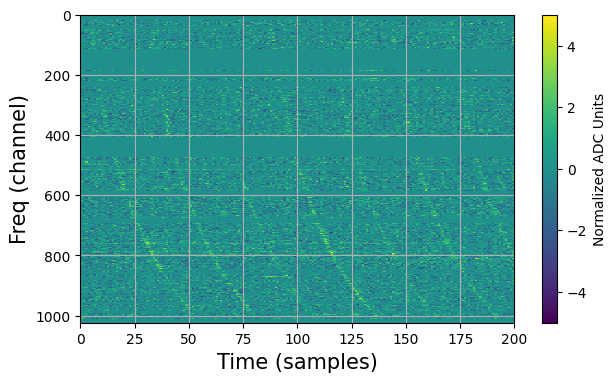

In [24]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(norm_pulsar_Fil_32.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_128.data, aspect='auto', interpolation = 'nearest')
# im = ax.imshow(norm_pulsar_Fil_150.data, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('Freq (channel)', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
ax.set_xlim(0, 200)
ax.grid(True)
cb = plt.colorbar(im, label = 'Normalized ADC Units')
im.set_clim(-5, 5)
plt.show()

# NOTE: MIGHT NOT BE NECESSARY TO INCLUDE THIS...

#### Spectrum

In [25]:
# #Add up the time samples
# pulsar_spectrum = np.sum(norm_pulsar_Fil.data, axis = 1)
# #make a quick waterfall plot of the pulsar data to see what we're working with
# fig, ax = plt.subplots(figsize = (7, 4))
# ax.plot(pulsar_spectrum)
# ax.set_title('RFI-Flagged and Normalized Pulsar Spectrum')
# ax.set_xlabel('Freq (channel)', fontsize = 15)
# ax.set_ylabel('Total ADC (counts)', fontsize = 15)
# ax.grid(True)
# plt.colorbar(im)
# plt.show()

# Rough work --------------------------------------

### Pulsar S/N

With the data flagged for RFI and correctly normalized, we can go ahead and compute and plot the S/N ratio per frequency of the pulsar data. From the results of the previous section, it seemed to be helpful to find the S/N of the average data set across all frequency channels, so this will be computed also.

In [26]:
# print(pulsar_masked_data.shape)
# # plt.plot(pulsar_masked_data_array)

In [27]:
# # #renaming for convenience
# pulsar_spectrum = np.sum(pulsar_masked_data_array, axis = 0)
# print(pulsar_spectrum)

# # #compute the S/N(freq)
# pulsar_SN = signal_to_noise(pulsar_spectrum, S_sys, 1)

# plt.plot(pulsar_spectrum)


# Rough work --------------------------------------

## Part 3: Pulsar S/N as a Function of DM and Time

In [28]:
# SN_DM_t = norm_pulsar_Fil_150.dmt_transform(30, dmsteps=20)
SN_DM_t = norm_pulsar_Fil_32.dmt_transform(30, dmsteps=1000)
print(type(SN_DM_t))
print(SN_DM_t.dms)

<class 'sigpyproc.block.DMTBlock'>
[ 0.          0.06006006  0.12012012  0.18018018  0.24024025  0.3003003
  0.36036035  0.4204204   0.4804805   0.5405405   0.6006006   0.6606607
  0.7207207   0.7807808   0.8408408   0.9009009   0.960961    1.021021
  1.081081    1.1411412   1.2012012   1.2612612   1.3213214   1.3813814
  1.4414414   1.5015016   1.5615616   1.6216216   1.6816816   1.7417418
  1.8018018   1.8618618   1.921922    1.981982    2.042042    2.102102
  2.162162    2.2222223   2.2822824   2.3423424   2.4024024   2.4624624
  2.5225224   2.5825825   2.6426427   2.7027028   2.7627628   2.8228228
  2.8828828   2.9429429   3.0030031   3.0630631   3.1231232   3.1831832
  3.2432432   3.3033032   3.3633633   3.4234235   3.4834836   3.5435436
  3.6036036   3.6636636   3.7237236   3.7837837   3.843844    3.903904
  3.963964    4.024024    4.084084    4.144144    4.204204    4.264264
  4.324324    4.384384    4.4444447   4.5045047   4.5645647   4.6246247
  4.6846848   4.744745    4.80480

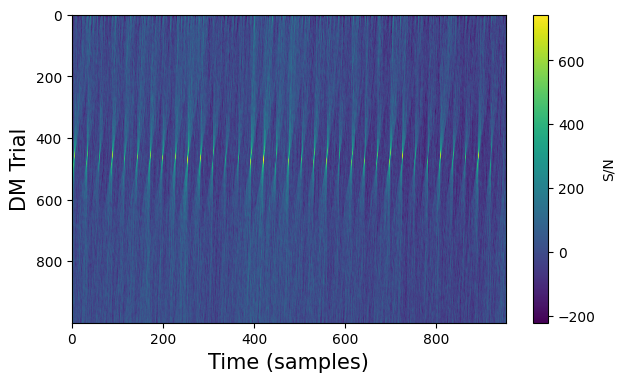

In [29]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(SN_DM_t.data, aspect='auto', interpolation = 'nearest')
ax.set_ylabel('DM Trial', fontsize = 15)
ax.set_xlabel('Time (samples)', fontsize = 15)
# ax.grid(True)
cb = plt.colorbar(im, label = 'S/N')
plt.show()

## Part 4: FT of S/N(DM, t)

In [30]:
Pretty(SN_DM_t.header)

Header(
    filename='pulsardata_masked_f1_t32.fil',
    data_type='filterbank',
    nchans=1,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.01048576,
    tstart=np.float64(60638.34381999473),
    nsamples=953,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info={
        'entries': [
            {
                'filename': 'pulsardata_masked_f1_t32.fil',
                'hdrlen': 414,
                'datalen': 3903488,
                'nsamples': 953,
                'tstart': 60638.34381999473,
                'tsamp': 0.01048576
            }
        ]
    }
)

In [31]:
# print(SN_DM_t.dms)

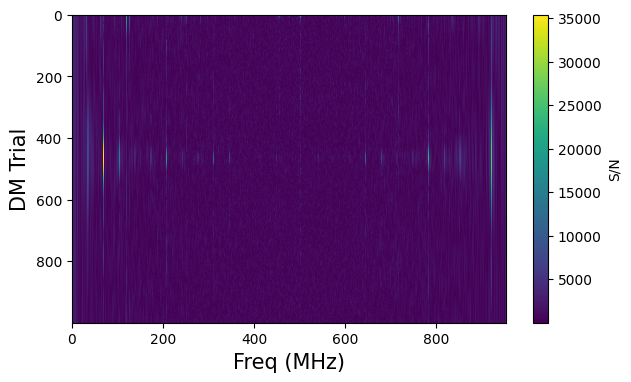

In [32]:
#calculate the FT and the associated frequency bins
SN_data_FT = np.fft.fft(SN_DM_t.data, axis = 1)
n_tsamples = SN_DM_t.data.shape[1]
SN_data_freqs = np.fft.fftfreq(n_tsamples)

fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(np.abs(SN_data_FT), aspect='auto', interpolation = 'nearest')
ax.set_ylabel('DM Trial', fontsize = 15)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
# ax.grid(True)
cb = plt.colorbar(im, label = 'S/N')
plt.show()

In [33]:
print(SN_data_freqs)

[ 0.          0.00104932  0.00209864  0.00314795  0.00419727  0.00524659
  0.00629591  0.00734523  0.00839454  0.00944386  0.01049318  0.0115425
  0.01259182  0.01364113  0.01469045  0.01573977  0.01678909  0.01783841
  0.01888772  0.01993704  0.02098636  0.02203568  0.02308499  0.02413431
  0.02518363  0.02623295  0.02728227  0.02833158  0.0293809   0.03043022
  0.03147954  0.03252886  0.03357817  0.03462749  0.03567681  0.03672613
  0.03777545  0.03882476  0.03987408  0.0409234   0.04197272  0.04302204
  0.04407135  0.04512067  0.04616999  0.04721931  0.04826863  0.04931794
  0.05036726  0.05141658  0.0524659   0.05351522  0.05456453  0.05561385
  0.05666317  0.05771249  0.0587618   0.05981112  0.06086044  0.06190976
  0.06295908  0.06400839  0.06505771  0.06610703  0.06715635  0.06820567
  0.06925498  0.0703043   0.07135362  0.07240294  0.07345226  0.07450157
  0.07555089  0.07660021  0.07764953  0.07869885  0.07974816  0.08079748
  0.0818468   0.08289612  0.08394544  0.08499475  0.

### Finding DM and Frequency maximizing S/N

First we find the max_DM by summing over the frequncy bins and determinin the max value.

In [34]:
max_DM_ind = np.argmax(np.sum(np.abs(SN_data_FT), axis = 1))
SN_FT_freq_avg = np.sum(np.abs(SN_data_FT), axis = 1)
max_DM = SN_DM_t.dms[max_DM_ind]
print(f"The max DM occurs at DM index {max_DM_ind} with the max DM at {max_DM:.4f}.")

The max DM occurs at DM index 461 with the max DM at 27.6877.


In [35]:
max_freq_ind = np.argmax(np.abs(SN_data_FT[max_DM_ind,:]))
max_freq = SN_data_freqs[max_freq_ind]
mf = max_freq*1e6
print(1/mf)
print(f"The frequency that maximizes the S/N is {max_freq:.4f}")
print(2*(1/(0.0724)*pulsar_masked_32_data.header.tsamp))

1.3811594202898552e-05
The frequency that maximizes the S/N is 0.0724
0.28966187845303865


In [36]:
# max_period_ind = np.argmax(np.sum(np.abs(SN_data_FT), axis = 0))
# print(f"The max frequency occurs at index {max_period}")

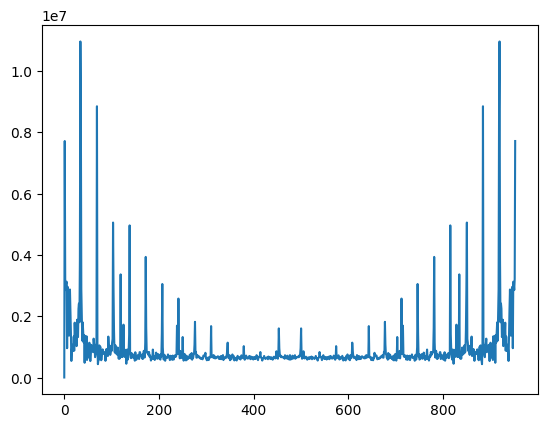

In [37]:
plt.plot(np.sum(np.abs(SN_data_FT), axis = 0))

In [38]:
# Z = np.abs(SN_data_FT)
# # Find the index of the maximum value in the array
# max_idx = np.argmax(Z)

# # Convert the flat index into 2D indices (row, column)
# max_row, max_col = np.unravel_index(max_idx, Z.shape)
# max_value = Z[max_row, max_col]

# print("Index of maximum value:", (max_row, max_col))
# print("Maximum function value:", max_value)

# # If you have corresponding coordinate arrays, e.g.,
# x_vals = np.linspace(Z[0,0], Z[0,-1], Z.shape[1])
# y_vals = np.linspace(Z[0,0], Z[0,-1], Z.shape[0])
# X, Y = np.meshgrid(x_vals, y_vals)

# # Retrieve the parameters corresponding to the maximum value
# max_x = X[max_row, max_col]
# max_y = Y[max_row, max_col]

# print("Parameters corresponding to the maximum value:", (max_x, max_y))

## Part 5: Folding the Data

In [46]:
period = 0.289 #period in seconds 
# dm = 27.89    #DM in units of (whatever DM is measured in)
dm = 25
pulsar_Fil_masked_32_folded = pulsar_Fil_masked_32.fold(
    period=period,
    dm=dm,
    nints=1,
    nbands=1024,
    nbins=int(period//pulsar_Fil_masked_32.header.tsamp)
)

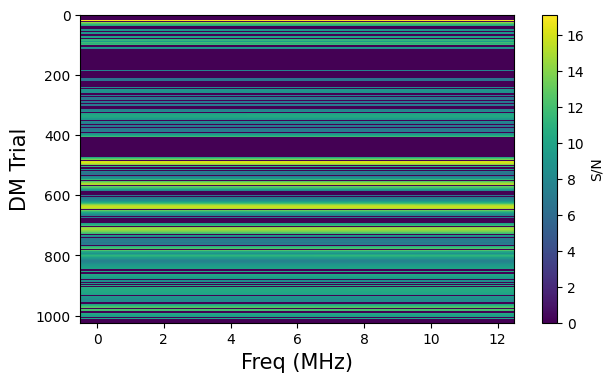

In [47]:
fig, ax = plt.subplots(figsize = (7, 4))
im = ax.imshow(pulsar_Fil_masked_32_folded.data[0,:,:], aspect='auto', interpolation = 'nearest')
ax.set_ylabel('DM Trial', fontsize = 15)
ax.set_xlabel('Freq (MHz)', fontsize = 15)
# ax.grid(True)
cb = plt.colorbar(im, label = 'S/N')
plt.show()

### Averaging over Frequency

In [48]:
tsteps = np.mean(pulsar_Fil_masked_32_folded.data[0,:,:], axis = 0).shape[0]
print(type(tsteps))

tvals = np.linspace(0, period, int(tsteps))

<class 'int'>


In [49]:
test =  np.linspace(0, 10, 100)

In [50]:
t = np.mean(pulsar_Fil_masked_32_folded.data[0,:,:], axis = 0).shape[0]
print(type(t))

<class 'int'>


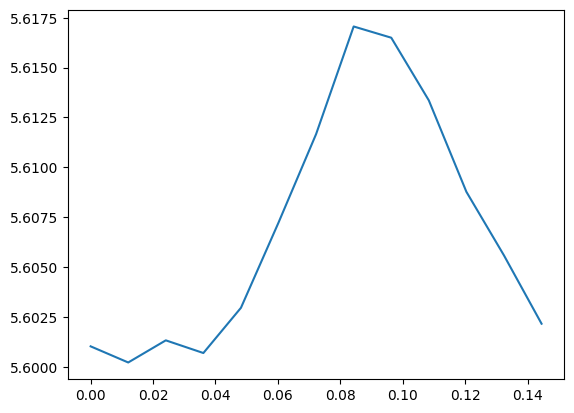

In [51]:
pulse_profile = np.mean(pulsar_Fil_masked_32_folded.data[0,:,:], axis = 0)
plt.plot(tvals, pulse_profile)

In [45]:
print(pulsar_Fil_masked_32_folded.data.shape)

(1, 1024, 27)
